In [40]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.utils import resample

#sklearn package 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn. preprocessing import LabelEncoder,StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB,MultinomialNB,GaussianNB 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier

#model evaluation
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,recall_score,precision_score,f1_score


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#read the dataset
data = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v2.json',lines=True) # lines for avoid the trailing error
column = data.columns
column

Index(['category', 'headline', 'authors', 'link', 'short_description', 'date'], dtype='object')

In [3]:
data.drop(['link','date'],axis=1,inplace = True)
data.head(4)

,category,headline,authors,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...


In [4]:
data.describe()

,category,headline,authors,short_description
count,200853,200853,200853,200853
unique,41,199344,27993,178353
top,POLITICS,Sunday Roundup,,
freq,32739,90,36620,19712


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   authors            200853 non-null  object
 3   short_description  200853 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


In [6]:
print("The shape of the dataset-------->",data.shape)
print("The number of null values ------>")
print(data.isnull().sum())
column = data.columns
print("The column present there-------->",column)

The shape of the dataset--------> (200853, 4)
The number of null values ------>
category             0
headline             0
authors              0
short_description    0
dtype: int64
The column present there--------> Index(['category', 'headline', 'authors', 'short_description'], dtype='object')


# Category walkthrough

In [7]:
print("The total number category present here------------->",data['category'].nunique())
category=data['category'].value_counts()
print(category)

The total number category present here-------------> 41
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE 

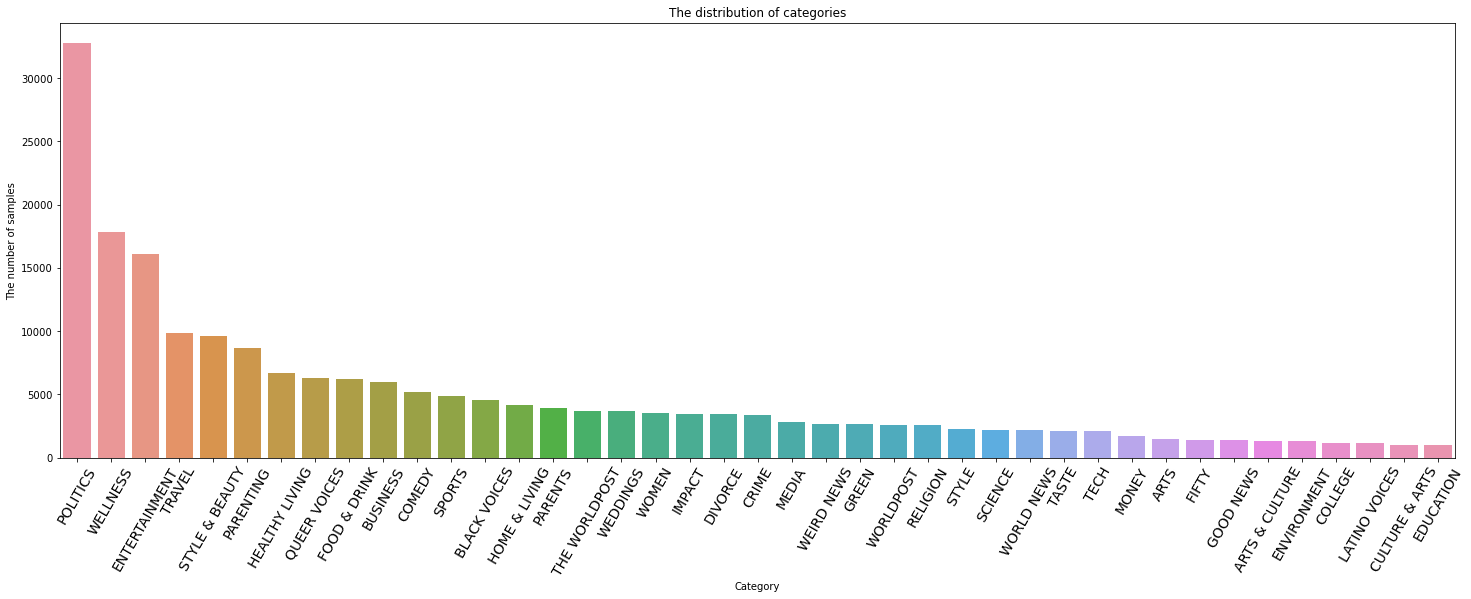

In [8]:
plt.figure(figsize=(25,8))
sns.barplot(x=category.index,y=category.values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.xticks(rotation=60,fontsize = 14)
plt.show()

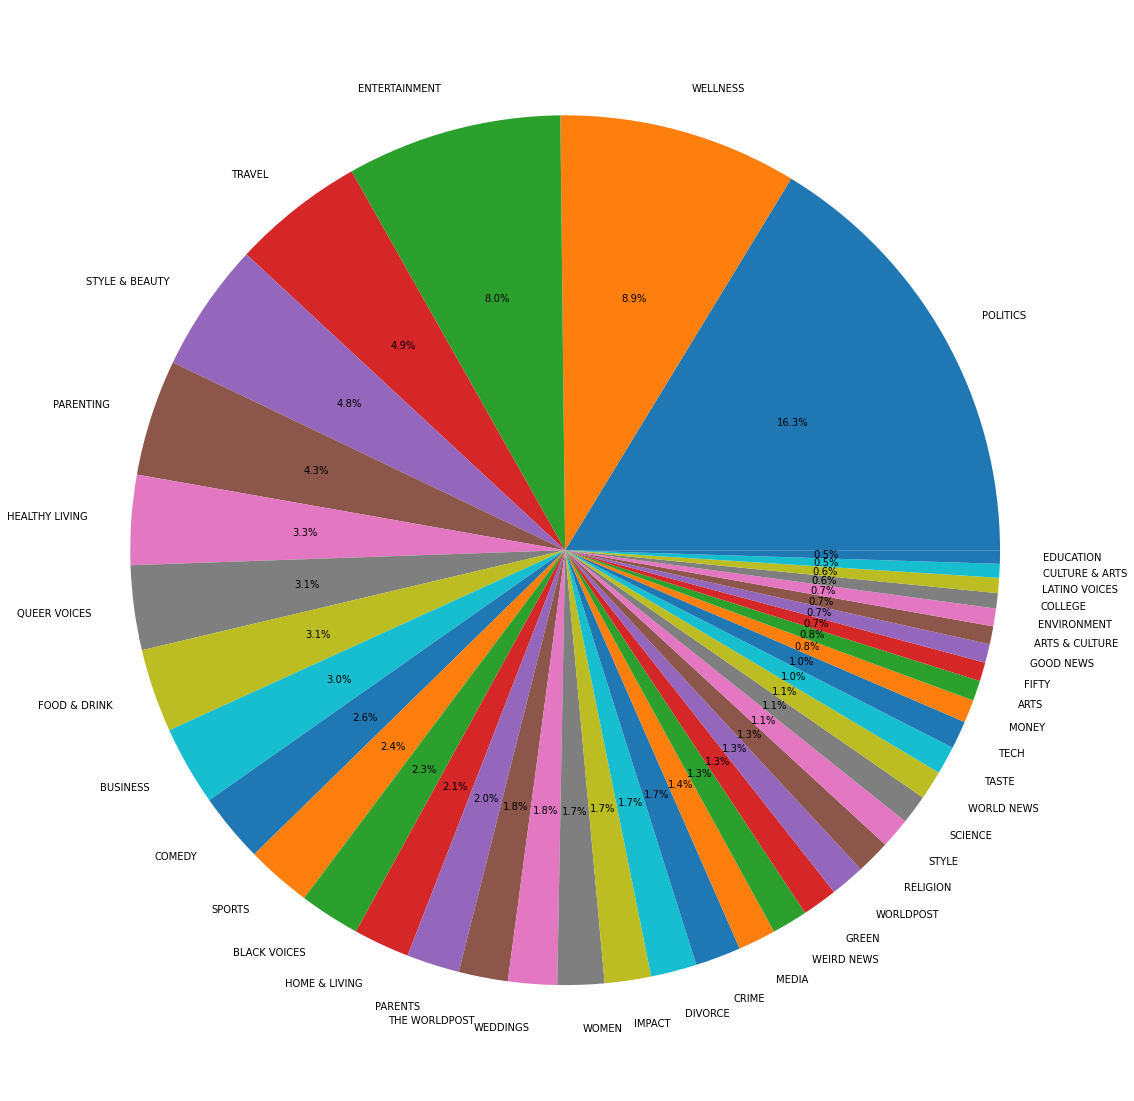

<Figure size 432x288 with 0 Axes>

In [9]:
#pie chart 
plt.figure(figsize=(20,20))
plt.pie(category.values, autopct="%1.1f%%", labels=category.index)
plt.show()
plt.savefig(r"./category_pie.png")

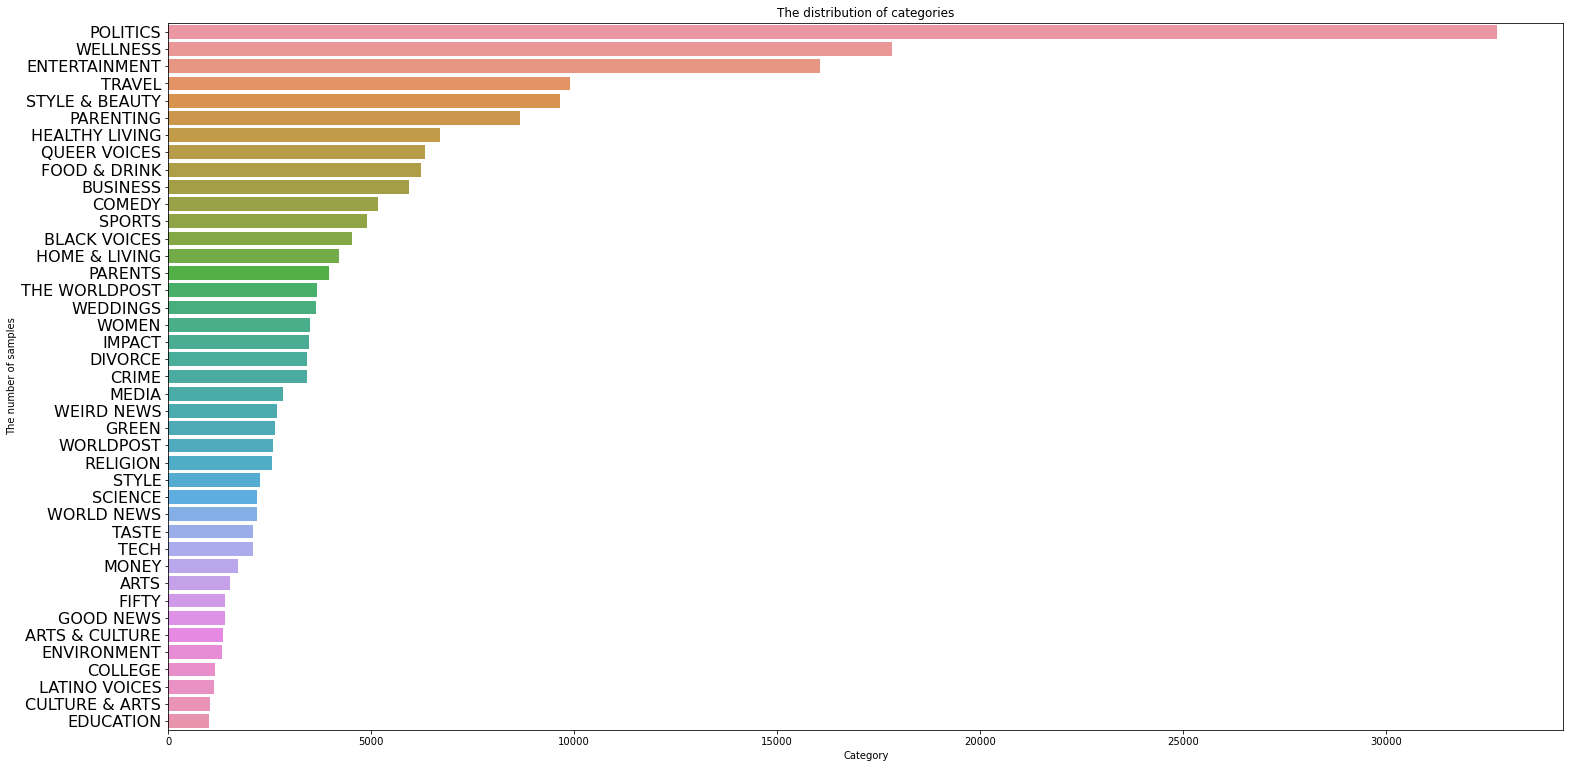

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(25,13))
sns.barplot(y=category.index,x=category.values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 16)
plt.show()
plt.savefig(r"./category_bar.png")

There are unqual number of sample in each category, so we can drop some category and make it balanced

# handling Dublicate and null values

In [11]:
#delete the dublicate values
data.duplicated().sum() # count the total duplicate samples

446

In [12]:
data.drop_duplicates(keep='last',inplace=True)

In [13]:
#there can be dublicate of author names so check for the dublicate headline and short discription
data.duplicated(subset=['headline', 'short_description']).sum()

42

In [14]:
data.drop_duplicates(subset=['headline', 'short_description'],inplace=True,keep='last')

In [15]:
print("THe length of the datset after dublicate deletion------>",data.shape)

THe length of the datset after dublicate deletion------> (200365, 4)


# Handling null values

In [16]:
data.isnull().sum()

category             0
headline             0
authors              0
short_description    0
dtype: int64

In [17]:
# there is no null value instead of null they are blank so we need to check for the blank placess and delete that
data[data['headline'] == '']

,category,headline,authors,short_description
86893,RELIGION,,"Matthew Fox, ContributorRadical theologian Mat...",Let everyone not wrapped in tired and disprove...
113471,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat...",


In [18]:
# drop the blank values
headline_blank = data['headline'] == ''
data = data[~headline_blank]
print("THe length of the datset ------>",data.shape)

THe length of the datset ------> (200363, 4)


In [19]:
#drop the blank short describtion column
description_blank = data['short_description']==''
print("the lenth of the blank description samples----->",len(data[description_blank]))
data = data[~description_blank]
print("THe length of the datset ---------------------->",data.shape)

the lenth of the blank description samples-----> 19610
THe length of the datset ----------------------> (180753, 4)


In [20]:
#drop the null author samples
author_blank = data['authors']==''
print("the lenth of the blank auhtor samples---------->",len(data[author_blank]))
data = data[~author_blank]
print("THe length of the datset ---------------------->",data.shape)

the lenth of the blank auhtor samples----------> 32055
THe length of the datset ----------------------> (148698, 4)


In [21]:
data.head(5)

,category,headline,authors,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,"The ""Dietland"" actress said using the bags is ..."


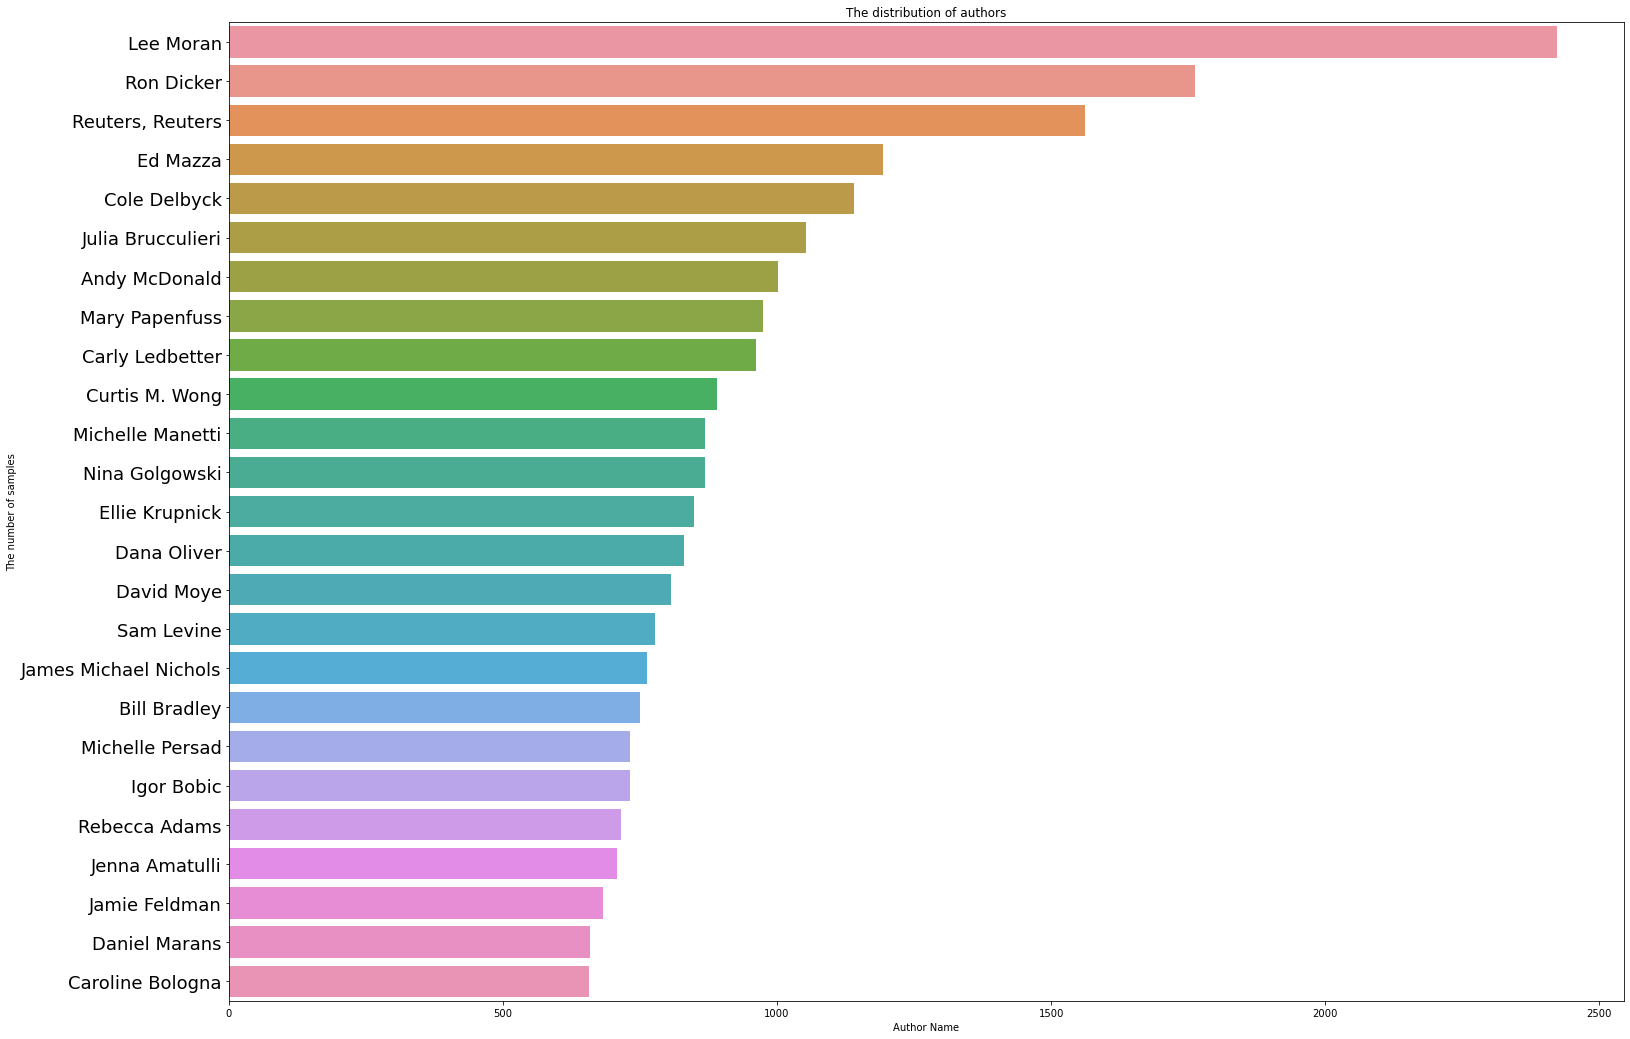

<Figure size 432x288 with 0 Axes>

In [22]:
#author 
#auhtor plot
auhtor_count = data['authors'].value_counts()

plt.figure(figsize=(25,18))
sns.barplot(y=auhtor_count[:25].index,x=auhtor_count[:25].values)
plt.title("The distribution of authors")
plt.xlabel("Author Name")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 18)
plt.show()
plt.savefig(r"./author_bar.png")

# Balance the category data

In [25]:
category = data['category'].value_counts()
list(category.index)

['POLITICS',
 'WELLNESS',
 'ENTERTAINMENT',
 'TRAVEL',
 'STYLE & BEAUTY',
 'PARENTING',
 'HEALTHY LIVING',
 'QUEER VOICES',
 'FOOD & DRINK',
 'BUSINESS',
 'COMEDY',
 'PARENTS',
 'SPORTS',
 'HOME & LIVING',
 'BLACK VOICES',
 'IMPACT',
 'WOMEN',
 'THE WORLDPOST',
 'MEDIA',
 'CRIME',
 'TASTE',
 'WEIRD NEWS',
 'WORLD NEWS',
 'RELIGION',
 'WEDDINGS',
 'DIVORCE',
 'GREEN',
 'TECH',
 'STYLE',
 'MONEY',
 'SCIENCE',
 'ARTS & CULTURE',
 'WORLDPOST',
 'FIFTY',
 'GOOD NEWS',
 'EDUCATION',
 'LATINO VOICES',
 'ARTS',
 'COLLEGE',
 'ENVIRONMENT',
 'CULTURE & ARTS']


we can drop the Style, Education, College and Environment they are having very less number of sample, which may lead to less accuracy and f1 score.

In [28]:
cateo_keep = (data['category'] == 'POLITICS') | (data['category'] == 'WELLNESS' )| (data['category'] == 'ENTERTAINMENT') | (data['category'] == 'TRAVEL') | \
            (data['category'] == 'STYLE & BEAUTY') | (data['category'] == 'PARENTING' )| (data['category'] == 'HEALTHY LIVING') | (data['category'] == 'QUEER VOICES') | \
              (data['category'] == 'FOOD & DRINK') | (data['category'] == 'BUSINESS' )| (data['category'] == 'COMEDY') | (data['category'] == 'PARENTS') | (data['category'] == 'SPORTS') | (data['category'] == 'HOME & LIVING' )| (data['category'] == 'BLACK VOICES')
data = data[cateo_keep]



In [30]:
category = data['category'].value_counts()
category

POLITICS          26901
WELLNESS          12827
ENTERTAINMENT     12190
TRAVEL             8008
STYLE & BEAUTY     7009
PARENTING          6405
HEALTHY LIVING     5071
QUEER VOICES       4668
FOOD & DRINK       4413
BUSINESS           4319
COMEDY             3709
PARENTS            3451
SPORTS             3445
HOME & LIVING      3365
BLACK VOICES       3257
Name: category, dtype: int64

In [42]:
data_1 = data[data['category'] == 'POLITICS']
data_1 = resample(data_1, replace=False, n_samples=3000, random_state=123)
data_2 = data[data['category'] == 'WELLNESS']
data_2 = resample(data_2, replace=False, n_samples=3000, random_state=123)
data_3 = data[data['category'] == 'ENTERTAINMENT']
data_3 = resample(data_3, replace=False, n_samples=3000, random_state=123)
data_4 = data[data['category'] == 'TRAVEL']
data_4 = resample(data_4, replace=False, n_samples=3000, random_state=123)
data_5 = data[data['category'] == 'STYLE & BEAUTY']
data_5 = resample(data_5, replace=False, n_samples=3000, random_state=123)
data_6 = data[data['category'] == 'PARENTING']
data_6 = resample(data_6, replace=False, n_samples=3000, random_state=123)
data_7 = data[data['category'] == 'HEALTHY LIVING']
data_7 = resample(data_7, replace=False, n_samples=3000, random_state=123)
data_8 = data[data['category'] == 'QUEER VOICES']
data_8 = resample(data_8, replace=False, n_samples=3000, random_state=123)
data_9 = data[data['category'] == 'FOOD & DRINK']
data_9 = resample(data_9, replace=False, n_samples=3000, random_state=123)
data_10 = data[data['category'] == 'BUSINESS']
data_10 = resample(data_10, replace=False, n_samples=3000, random_state=123)
data_11 = data[data['category'] == 'COMEDY']
data_11 = resample(data_11, replace=False, n_samples=3000, random_state=123)
data_12= data[data['category'] == 'PARENTS']
data_12 = resample(data_12, replace=False, n_samples=3000, random_state=123)
data_13= data[data['category'] == 'SPORTS']
data_13 = resample(data_13, replace=False, n_samples=3000, random_state=123)
data_14 = data[data['category'] == 'HOME & LIVING']
data_14 = resample(data_14, replace=False, n_samples=3000, random_state=123)
data_15 = data[data['category'] == 'BLACK VOICES']
data_15 = resample(data_15, replace=False, n_samples=3000, random_state=123)

cato_list = [data_1 , data_2 , data_3 , data_4 ,data_5 , data_6 , data_7, data_8 , data_9 , data_10, data_11 , data_12 , data_13, data_14 ,data_15]

data = pd.concat(cato_list)
data['category'].value_counts()

ENTERTAINMENT     3000
HEALTHY LIVING    3000
FOOD & DRINK      3000
PARENTS           3000
QUEER VOICES      3000
POLITICS          3000
PARENTING         3000
BLACK VOICES      3000
COMEDY            3000
STYLE & BEAUTY    3000
SPORTS            3000
TRAVEL            3000
HOME & LIVING     3000
WELLNESS          3000
BUSINESS          3000
Name: category, dtype: int64

In [ ]:
category = data['category'].value_counts()
plt.figure(figsize=(25,13))
sns.barplot(y=category.index,x=category.values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 16)
plt.show()
plt.savefig(r"./category_bar.png")

# Column Combinning

In [ ]:
data['text'] = data['headline']+'-'+data['short_description']

In [ ]:
data.head(4)

In [ ]:
#drop the other columns
data.drop(['authors','headline','short_description'],axis=1,inplace=True)

In [ ]:
print("The lenth of the datset-------------------->",data.shape)
data.head(4)

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)
data.reset_index(inplace=True, drop=True) 
data.head(4)

# test cleaning

In [ ]:
"""corpus=[]
for i in range(100000):
    text = data.iloc[i,1]
    
    text = text.lower()
    text = re.sub('[^a-z0-9]',' ',text)
    text = text.split()
    
    s = PorterStemmer()
    text = [s.stem(word) for word in text if not word in set(stopwords.words('english')) ]
    text = ' '.join(text)
    corpus.append(text)
    
    if i%1000==0:
        print(i,end='->')"""


In [ ]:
"""corpus = pd.read_csv('../input/corpus/corpus.csv')
corpus"""


# Tokazitation and Count Vectorization

In [ ]:
#train and test split
X = data['text']
#label encoding the target
label = LabelEncoder()
y = label.fit_transform(data['category'])

#split the train and test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=2)

In [ ]:
print("The X_train shape----->",X_train.shape)
print('The X_text shape------>',X_test.shape)
print("THe y_train shape----->",y_train.shape)
print("The y_test shape------>",y_test.shape)

In [ ]:
#ifidf vectorizer

vecto =  TfidfVectorizer(stop_words='english',max_df = 0.99,min_df=10,
                                   ngram_range=(1, 2),lowercase=True, max_features=5000)
vecto = vecto.fit(X_train)

X_train = vecto.transform(X_train).toarray()
X_test = vecto.transform(X_test).toarray()
X_train.shape

In [ ]:
print(vecto.get_feature_names())

In [ ]:
tfidf_df = pd.DataFrame(X_train,columns = vecto.get_feature_names())
tfidf_df.head(4)

In [ ]:
print("The X_train shape----->",X_train.shape)
print('The X_text shape------>',X_test.shape)
print("THe y_train shape----->",y_train.shape)
print("The y_test shape------>",y_test.shape)

# Model training

In [ ]:

def classifier_scores(y_train,y_test, pred_train, pred_test):
    
    print()
    print("Train data accuracy score: ", accuracy_score(y_train,pred_train))    
    print("Test data accuracy score: ", accuracy_score(y_test,pred_test))
    print()
    print("Recall score on train data: ", recall_score(y_train,pred_train, average='macro'))
    print("Recall score on test data: ",recall_score( y_test,pred_test, average='macro'))
    print()
    
    print("Precision score on train data: ",precision_score(y_train,pred_train, average='macro'))
    print("Precision score on test data: ",precision_score(y_test,pred_test, average='macro'))
    print()
    print("F1 score on train data: ",f1_score(y_train,pred_train, average='macro'))
    print("F1 score on test data: ",f1_score(y_test,pred_test, average='macro'))

## Multinomial Naive Bayes

In [ ]:
print("Multinamial NB----------------------------------->")
multinb = MultinomialNB()
multinb.fit(X_train , y_train)

y_train_pred = multinb.predict(X_train)
y_test_pred = multinb.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)

## Complement Naive Bayes

In [ ]:
print("Compiment NB----------------------------------->")
compnb = ComplementNB(alpha=1.0)
compnb.fit(X_train , y_train)

y_train_pred = compnb.predict(X_train)
y_test_pred = compnb.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)

## Gaussian Naive Bayes

In [ ]:
#model training
gaussion_NB = GaussianNB()
gaussion_NB.fit(X_train , y_train)

y_train_pred = gaussion_NB.predict(X_train)
y_test_pred = gaussion_NB.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)

## logistic Regresssion

In [ ]:
#logistic Regresssion

log_reg = LogisticRegression()

log_reg.fit(X_train , y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)

In [ ]:
#logistric regression more accuracy
log_reg_hyper = LogisticRegression(solver='liblinear',n_jobs=-1,penalty='l2',)
log_reg_hyper.fit(X_train , y_train)

y_train_pred = log_reg_hyper.predict(X_train)
y_test_pred = log_reg_hyper.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)

## Gradient Boosting Classifier

In [ ]:
#GradientBoostingClassifier 

gb_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0)
gb_clf.fit(X_train, y_train)


    
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)
print('-'*56)

### Model training with SVD

In [ ]:
n_com = [500,1000,2000,3000]
def models_prepare():
    model = {}
    for n in n_com:
        s = [('svd',TruncatedSVD(n_components = n)),('logistric',LogisticRegression())]
        model[str(n)] = Pipeline(steps = s)
    return model
models = models_prepare()
models

In [ ]:

for name,model in models.items():
    model.fit(X_train,y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("The Logistric Regression Trained with svd n_components {} ".format(name))
    
    classifier_scores(y_train,y_test,y_pred_train,y_pred_test)

# save the best model for later use

In [ ]:
import pickle
# save the model to disk

print("Loding your model..................")
file_path = './logistricRegression_text_classi.sav'
pickle.dump(log_reg, open(file_path, 'wb'))
 
print('Model saved......')
 


In [ ]:
# load the model from disk
loaded_model = pickle.load(open(file_path, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)